# Краткое напоминание: Линейная регрессия

Имеем датасет:  
$$
L = \{x_i, y_i\}_{i=1}^N,\quad x_i \in \mathbb{R}^n,\quad y_i \in \mathbb{R}
$$

Модель линейная:  
$$
\hat{y} = w_0 + \sum\limits_{k=1}^{n} x_k \cdot w_k = \mathbf{x}^T \mathbf{w}
$$

где  
$$
\mathbf{x} = [1, x_1, x_2, \ldots, x_n]^T,\quad
\mathbf{w} = (w_0, w_1, \ldots, w_n)^T
$$

а $w_0$ отвечает за смещение.

---

Тогда параметры модели можно найти следующим образом:  
$$
\hat{\mathbf{w}} = \arg\min\limits_{\mathbf{w}} L(Y, \hat{Y}) = \arg\min\limits_{\mathbf{w}} L(Y, X\mathbf{w})
$$

где $X$ — матрица, в строках которой записаны обучающие примеры $\mathbf{x}_i$,  
в вектор $Y$ записаны обучающие метки $y_i$,  
а $L(Y, \hat{Y})$ — некоторая функция потерь.

---

Функция потерь в выражении выше может быть различной.  
Наиболее часто используют L2 норму (MSE) и L1 норму (MAE).

При использовании L2 нормы в качестве функции потерь получим метод наименьших квадратов:  
$$
\hat{\mathbf{w}} = \arg\min\limits_{\mathbf{w}} \|Y - X\mathbf{w}\|_2^2
$$

# Аналитическое решение

Введем квадратичную функцию потерь: $Q({\bf w}) = ||Y - X{\bf w}||_2^2 = (Y - X{\bf w})^T (Y - X{\bf w})$

Для нахождения оптимума приравняем к нулю производную:
$$\mathop{\nabla}_{{\bf w}} Q({\bf w}) = \mathop{\nabla}_{{\bf w}} [Y^T Y - Y^T X {\bf w} - {\bf w}^T X^T Y + {\bf w}^T X^T X {\bf w}] = \\
= 0 - X^T Y - X^T Y + (X^T X + X^T X){\bf w} = 0$$

Таким образом,
$$\hat{{\bf w}} = (X^T X)^{-1} X^T Y$$

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 16.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import optuna
import joblib
from google.colab import drive

# Монтируем диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/datacon_2025/ml/data/chembl.csv"

df = pd.read_csv(DATA_PATH)
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
display(df.sample(6))
print(df.shape)
df.info()

,MOL,pValue,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
357,c1ccc(CCc2cc(NCc3cccc4ccccc34)nc(NCc3ccccc3)n2...,3.000000,4.806246,4.806246,0.647995,0.647995,0.267551,10.823529,444.582,416.358,...,0,0,0,0,0,0,0,0,0,0
237,Oc1ccc([C@@H]2Oc3ccc(O)cc3[C@@H]3C[C@H](C(F)(F...,7.906578,13.314958,13.314958,0.002543,-4.242228,0.768756,28.120000,350.336,333.200,...,0,0,0,0,0,0,0,0,0,0
89,CN(CCCc1ccc(Cl)cc1)c1nc(NCCc2ccc(O)cc2)nc(N2CC...,5.886057,13.015252,13.015252,0.233957,-3.564270,0.205104,14.133333,648.233,609.929,...,0,1,0,0,0,0,0,0,0,0
216,CS(=O)(=O)c1ccc(-c2ccc3cc(O)ccc3c2Oc2ccc(OCCN3...,9.327902,11.908385,11.908385,0.175704,-3.290930,0.296768,14.513514,517.647,486.399,...,0,0,1,0,0,0,0,0,0,0
572,O=S(=O)(Oc1cccc(/C=C/c2cc(O)cc(O)c2)c1)C1CC2OC...,6.197534,13.605074,13.605074,0.073889,-4.139183,0.168199,20.146341,570.619,544.411,...,0,0,0,0,0,0,0,0,0,0
601,CCN(c1ccccc1Br)S(=O)(=O)C1CC2OC1C(c1ccc(NC(=O)...,6.272069,14.216914,14.216914,0.119328,-3.835692,0.157494,19.111111,697.648,660.352,...,0,1,0,0,0,0,0,0,3,0


(699, 219)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Columns: 219 entries, MOL to fr_urea
dtypes: float64(108), int64(110), object(1)
memory usage: 1.2+ MB


<Axes: xlabel='pValue', ylabel='Count'>

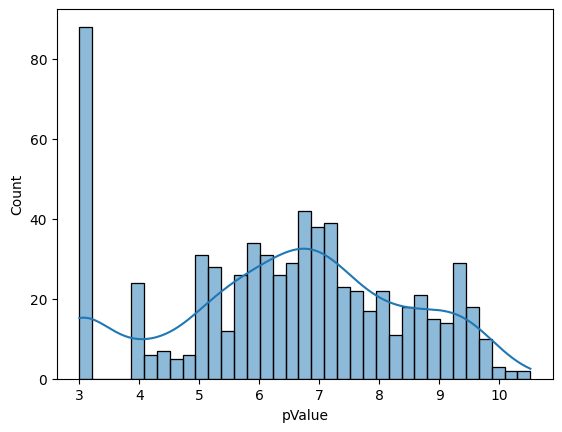

In [ ]:
sns.histplot(df, x="pValue", kde=True, bins=35)

In [ ]:
sns.violinplot(df, x="pValue")

In [ ]:
print("Полных дубликатов:", df.duplicated().sum())
print("Пропусков по колонкам:\n", df.isna().sum().sort_values(ascending=False).head(100))

Полных дубликатов: 10
Пропусков по колонкам:
 MOL                  0
pValue               0
MaxAbsEStateIndex    0
MaxEStateIndex       0
MinAbsEStateIndex    0
                    ..
EState_VSA8          0
EState_VSA9          0
VSA_EState1          0
VSA_EState10         0
VSA_EState2          0
Length: 100, dtype: int64


In [ ]:
df = df.drop_duplicates()
print("Полных дубликатов после чистки:", df.duplicated().sum())

Полных дубликатов после чистки: 0


2 этап

In [ ]:
# 1. Отбрасываем служебные колонки
drop_cols = "MOL"
df_clean = df.drop(columns=drop_cols)

# 2. Целевой вектор y
y = df_clean["pValue"].values
X = df_clean.drop(columns="pValue").copy()

# 3. Приводим все int→float (деревья терпят, но CatBoost/LGBM любят float32)
X = X.astype(np.float32)

# 4. Удаляем константные/квази-константные признаки (<1e-4 дисперсия)
vt = VarianceThreshold(threshold=1e-4)
X = vt.fit_transform(X)
print("После VarianceThreshold shape:", X.shape)

# 5. Единственный сплит: 80 / 20 stratified по квантилям pValue
bins = pd.qcut(y, q=10, duplicates="drop", labels=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=bins
)
print("Train:", X_train.shape, " Test:", X_test.shape)

/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py:133: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
# 1) Маски inf / -inf
mask_inf_pos = np.isposinf(X)
mask_inf_neg = np.isneginf(X)

print("+inf count:", mask_inf_pos.sum())
print("-inf count:", mask_inf_neg.sum())

# 2) Маска «слишком большие» (порог поставим 1e6 - для химических дескрипторов это подозрительно)
mask_huge = (np.abs(X) > 1e6).sum(axis=0)
huge_cols = X.columns[mask_huge > 0]
print("Колонок с |value| > 1e6:", len(huge_cols))

+inf count: MaxAbsEStateIndex    0
MaxEStateIndex       0
MinAbsEStateIndex    0
MinEStateIndex       0
qed                  0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 217, dtype: int64
-inf count: MaxAbsEStateIndex    0
MaxEStateIndex       0
MinAbsEStateIndex    0
MinEStateIndex       0
qed                  0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 217, dtype: int64
Колонок с |value| > 1e6: 1


In [ ]:
# 0) выясняем имя колонки-гиганта
print(huge_cols)

# 1) удаляем её:
X = X.drop(columns=huge_cols)

# 2) приводим к float32
X = X.astype(np.float32)
X_raw = X.copy()
# 3) VarianceThreshold
vt = VarianceThreshold(threshold=1e-4)
X = vt.fit_transform(X)
print("После очистки и VT shape:", X.shape)

# 4) Stratified split
bins = pd.qcut(y, q=10, duplicates="drop", labels=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=bins
)

# 5) Dummy baseline
dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)
mae_dummy = mean_absolute_error(y_test, dummy.predict(X_test))
r2_dummy  = r2_score(y_test, dummy.predict(X_test))

print(f"Dummy MAE: {mae_dummy:.4f}")
print(f"Dummy R2 : {r2_dummy:.4f}")

Index(['Ipc'], dtype='object')
После очистки и VT shape: (689, 189)
Dummy MAE: 1.6359
Dummy R2 : -0.0004


In [ ]:
plt.figure(figsize=(8, 5))

sns.histplot(y_train, kde=True, bins=35, color="blue", label="Train", stat="density", alpha=0.5)
sns.histplot(y_test, kde=True, bins=35, color="orange", label="Test", stat="density", alpha=0.5)

plt.xlabel("pValue")
plt.ylabel("Density")
plt.title("Распределения pValue при разбиении на бины: Train vs Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Строим бины (10 квантилей pValue)
y_train_bins = pd.qcut(y_train, q=10, duplicates='drop', labels=False)

# Генератор фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_indices = list(cv.split(X_train, y_train_bins))

In [ ]:
# Скореры
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = "r2"

pipe_enet = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNetCV(
        l1_ratio=[.1, .5, .9, .95, 1.0],
        alphas=np.logspace(-4, 1, 30),
        cv=5,
        random_state=42,
        n_jobs=-1
    ))
])

mae_scores = cross_val_score(pipe_enet, X_train, y_train, cv=cv_indices,
                             scoring=mae_scorer, n_jobs=-1)
r2_scores = cross_val_score(pipe_enet, X_train, y_train, cv=cv_indices,
                             scoring=r2_scorer, n_jobs=-1)

print("ElasticNet  |  MAE {:.3f} ± {:.3f} | R2 {:.3f} ± {:.3f}"
      .format(-mae_scores.mean(), mae_scores.std(),
              r2_scores.mean(),   r2_scores.std()))

ElasticNet  |  MAE 0.729 ± 0.044 | R² 0.751 ± 0.045


In [ ]:
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

mae_scores = cross_val_score(rf, X_train, y_train, cv=cv_indices,
                             scoring=mae_scorer, n_jobs=-1)
r2_scores = cross_val_score(rf, X_train, y_train, cv=cv_indices,
                             scoring=r2_scorer, n_jobs=-1)

print("RandomForest | MAE {:.3f} ± {:.3f} | R2 {:.3f} ± {:.3f}"
      .format(-mae_scores.mean(), mae_scores.std(),
              r2_scores.mean(),   r2_scores.std()))

RandomForest | MAE 0.561 ± 0.032 | R² 0.828 ± 0.025


In [ ]:
lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

mae_scores = cross_val_score(lgbm, X_train, y_train, cv=cv_indices,
                             scoring=mae_scorer, n_jobs=-1)
r2_scores = cross_val_score(lgbm, X_train, y_train, cv=cv_indices,
                             scoring=r2_scorer, n_jobs=-1)

print("LightGBM | MAE {:.3f} ± {:.3f} | R2 {:.3f} ± {:.3f}"
      .format(-mae_scores.mean(), mae_scores.std(),
              r2_scores.mean(),   r2_scores.std()))

LightGBM | MAE 0.555 ± 0.034 | R² 0.833 ± 0.023


Оптимизация гиперпараметров

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestRegressor(**params)
    score = cross_val_score(
        model, X_train, y_train,
        cv=cv_indices,             # те же фолды
        scoring=mae_scorer,
        n_jobs=-1
    )
    return -score.mean()          # MAE минимизируем

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50,) #timeout=600)   # можно увеличить n_trials при желании

print("Лучшие параметры:")
print(study.best_params)

[I 2025-07-10 07:08:26,632] A new study created in memory with name: no-name-d7f56163-e880-4a69-bff2-fd38c49438b0
[I 2025-07-10 07:09:18,981] Trial 0 finished with value: 0.5720295090609057 and parameters: {'n_estimators': 602, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.5720295090609057.
[I 2025-07-10 07:09:47,420] Trial 1 finished with value: 0.5736555860480435 and parameters: {'n_estimators': 359, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.5720295090609057.
[I 2025-07-10 07:10:10,403] Trial 2 finished with value: 0.5599834126029613 and parameters: {'n_estimators': 246, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.5599834126029613.
[I 2025-07-10 07:10:28,150] Trial 3 finished with value: 0.5824898965006404 and parameters: {'n_estimators': 240, 'max_depth': 14, 'min_sam

Лучшие параметры:
{'n_estimators': 374, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}


In [ ]:
best_params = study.best_params
best_params["random_state"] = 42
best_params["n_jobs"] = -1

model_final = RandomForestRegressor(**best_params)
model_final.fit(X_train, y_train)

# Кросс-валидация для оценки финальной модели
mae_scores = cross_val_score(model_final, X_train, y_train, cv=cv_indices,
                             scoring=mae_scorer, n_jobs=-1)
r2_scores = cross_val_score(model_final, X_train, y_train, cv=cv_indices,
                             scoring=r2_scorer, n_jobs=-1)

print("CV после Optuna | MAE {:.3f} ± {:.3f} | R2 {:.3f} ± {:.3f}"
      .format(-mae_scores.mean(), mae_scores.std(),
              r2_scores.mean(),   r2_scores.std()))

CV после Optuna | MAE 0.556 ± 0.033 | R2 0.830 ± 0.025


In [ ]:
y_pred_test = model_final.predict(X_test)

print("Hold-out Test Results:")
print("MAE (test):", mean_absolute_error(y_test, y_pred_test))
print("R2  (test):", r2_score(y_test, y_pred_test))

Hold-out Test Results:
MAE (test): 0.535338699674841
R2  (test): 0.8408798769486039


In [ ]:
!pip install shap

 99%|===================| 544/551 [01:01<00:00]       

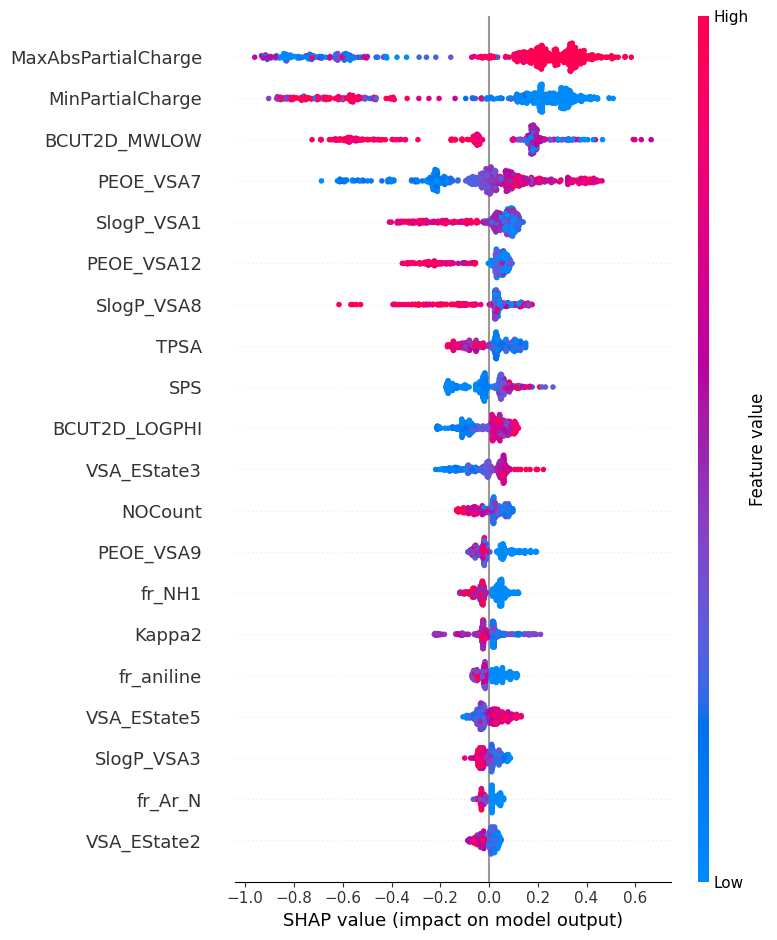

In [ ]:
import shap

# 1. Восстановим имена признаков
# X до VT должен быть DataFrame, сохраним его перед VT:

# Потом:
feature_names = X_raw.columns[vt.get_support()]  # маска оставшихся признаков

# 2. Превратим X_train обратно в DataFrame
X_named = pd.DataFrame(X_train, columns=feature_names)

# 3. Создадим explainer и SHAP значения
explainer = shap.Explainer(model_final, X_named)
shap_values = explainer(X_named)

# 4. Построим summary plot
shap.summary_plot(shap_values, X_named)


Сохраняем модель

In [ ]:
# Сохраняем модель
joblib.dump(model_final, "model_rf_optuna.pkl")

# Сохраняем VarianceThreshold (если использовали)
joblib.dump(vt, "vt_selector.pkl")

# Если сохраняли имена признаков до VT:
# joblib.dump(feature_names_after_vt, "feature_names.pkl")


['vt_selector.pkl']

In [ ]:
# Загружаем сохранённую модель
model = joblib.load("model_rf_optuna.pkl")
vt = joblib.load("vt_selector.pkl")

# Загружаем новые данные
df_new = pd.read_csv("../../../nn/data/selected_mol_after_generation.csv")

# Удаляем служебные колонки, если есть
df_new = df_new.drop(columns=["is_valid", "Unnamed: 0", "Ipc"], errors='ignore')

# Приводим к float32
X_new = df_new.astype(np.float32)

# Применяем отбор признаков (тот же VT, что был на train)
X_new_transformed = vt.transform(X_new)

In [ ]:
# Предсказания
y_pred_new = model.predict(X_new_transformed)

# Добавим к датафрейму
#df_new["pValue_pred"] = y_pred_new

# Сохраняем
#df_new.to_csv("new_data_with_preds.csv", index=False)

In [ ]:
y_pred_new

array([7.78725927])